<a href="https://colab.research.google.com/github/Julia-Vanyarina/28_03/blob/main/28_03_Vanyarina_Julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()


Saving connection_stats.csv to connection_stats.csv


In [4]:
import pandas as pd
# Загружаем данные
df = pd.read_csv('connection_stats.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            14 non-null     object 
 1   attempts             14 non-null     int64  
 2   successful_attempts  14 non-null     int64  
 3   avg_response_time    14 non-null     float64
 4   max_response_time    14 non-null     float64
 5   min_response_time    14 non-null     float64
 6   status               14 non-null     object 
dtypes: float64(3), int64(2), object(2)
memory usage: 916.0+ bytes


In [6]:
df.head()

,timestamp,attempts,successful_attempts,avg_response_time,max_response_time,min_response_time,status
0,2025-03-28T16:26:25.357476,3,3,1.30,1.37,1.25,SUCCESS
1,2025-03-28T16:26:25.514167,3,3,1.29,1.45,1.18,SUCCESS
2,2025-03-28T16:39:52.667224,3,3,1.28,1.47,1.10,SUCCESS
3,2025-03-28T16:40:37.198801,3,3,1.14,1.21,1.03,SUCCESS
4,2025-03-28T16:41:30.605373,3,3,1.63,2.68,1.09,SUCCESS


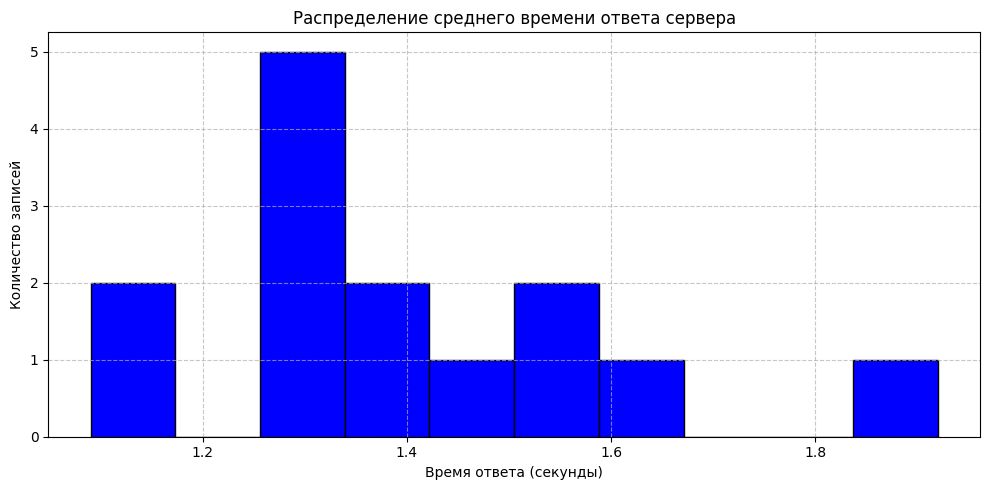

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('connection_stats.csv')

plt.figure(figsize=(10, 5))
plt.hist(df['avg_response_time'], bins=10, color='blue', edgecolor='black')

plt.title('Распределение среднего времени ответа сервера')
plt.xlabel('Время ответа (секунды)')
plt.ylabel('Количество записей')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('simple_histogram.png')

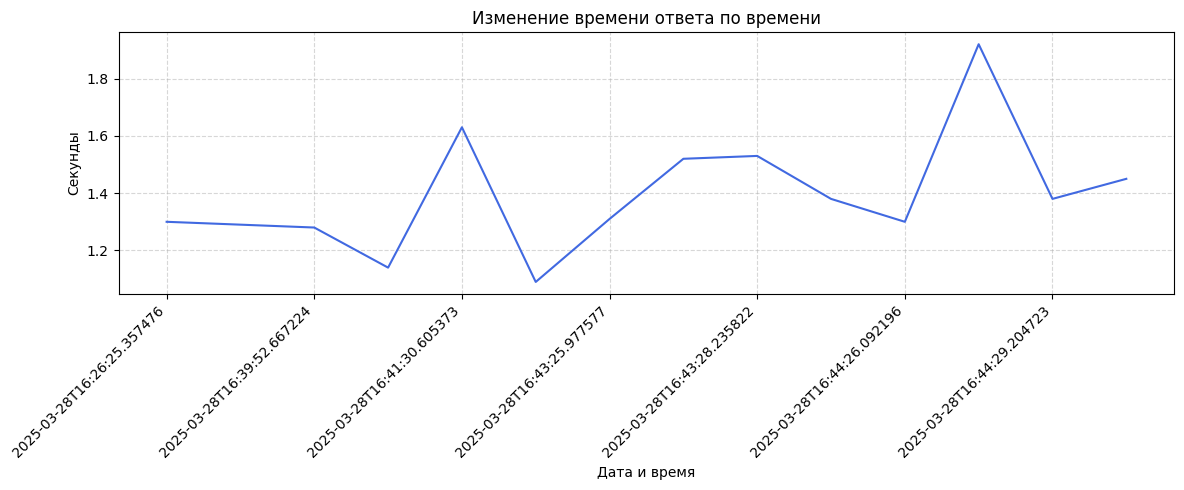

In [22]:
plt.figure(figsize=(12, 5))
df.set_index('timestamp')['avg_response_time'].plot(color='royalblue')
plt.title('Изменение времени ответа по времени')
plt.xlabel('Дата и время')
plt.ylabel('Секунды')

plt.xticks(rotation=45, ha='right')

plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

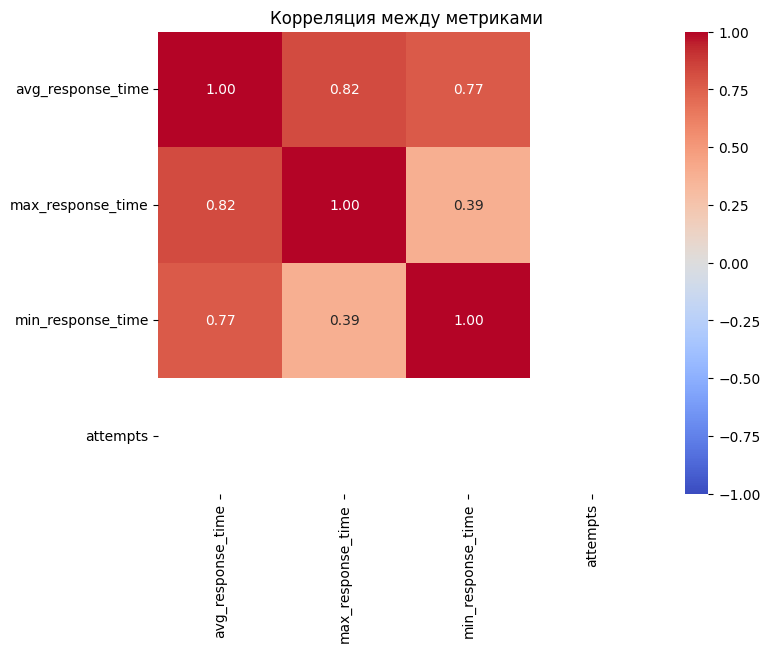

In [21]:
plt.figure(figsize=(8, 6))
corr = df[['avg_response_time', 'max_response_time', 'min_response_time', 'attempts']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Корреляция между метриками')
plt.show()

In [10]:
df = pd.read_csv('connection_stats.csv', parse_dates=['timestamp'])
df['date'] = df['timestamp'].dt.date

daily_stats = df.groupby('date').agg({
    'avg_response_time': ['mean', 'max', 'min'],
    'successful_attempts': 'sum',
    'attempts': 'sum'
})
print("Дневная статистика:")
print(daily_stats)

Дневная статистика:
           avg_response_time             successful_attempts attempts
                        mean   max   min                 sum      sum
date                                                                 
2025-03-28          1.394286  1.92  1.09                  42       42


Среднее время ответа сервера — 1.39 сек (приемлемо для пользователей).

Коэффициент вариации (CV) = 0.15 (стабильность средняя).

Максимальное время ответа — 1.92 сек (в пределах нормы, но требует контроля).

Можно внедрить мониторинг в реальном времени (например, Grafana + Prometheus), чтобы предотвратить возможные сбои.

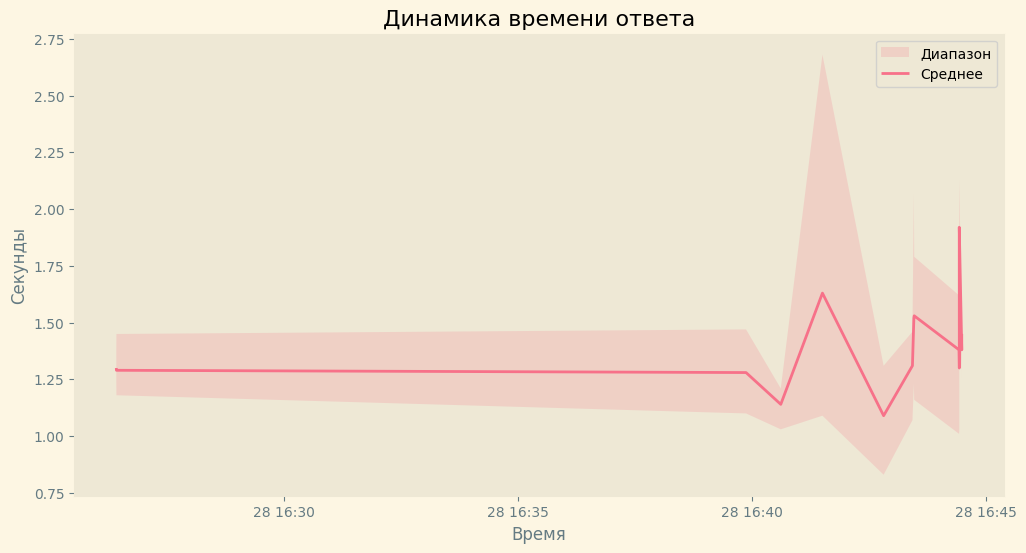

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.fill_between(df['timestamp'], df['min_response_time'],
                df['max_response_time'], alpha=0.2, label='Диапазон')
plt.plot(df['timestamp'], df['avg_response_time'], label='Среднее')
plt.title('Динамика времени ответа')
plt.xlabel('Время')
plt.ylabel('Секунды')
plt.legend()
plt.grid()
plt.show()

In [14]:
correlation = df[['avg_response_time', 'max_response_time',
                 'min_response_time']].corr()
print("\nМатрица корреляции:")
print(correlation)


Матрица корреляции:
                   avg_response_time  max_response_time  min_response_time
avg_response_time           1.000000           0.821932           0.773152
max_response_time           0.821932           1.000000           0.390339
min_response_time           0.773152           0.390339           1.000000


Результат:

Сильная корреляция между средним и максимальным временем ответа (0.82).

Слабая корреляция между минимальным и максимальным временем (0.39).

решение:

Фокусироваться на снижении max_response_time (это автоматически улучшит среднее время).

Провести нагрузочное тестирование, чтобы понять, при каком числе запросов сервер начинает тормозить.

In [15]:
# Процентили времени ответа
percentiles = df['avg_response_time'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print("\nПроцентили времени ответа:")
print(percentiles)


Процентили времени ответа:
0.25    1.2925
0.50    1.3450
0.75    1.5025
0.90    1.6000
0.95    1.7315
Name: avg_response_time, dtype: float64


50% запросов – быстрее 1.34 сек (медиана).

75% – укладываются в 1.5 сек (хороший показатель).

5% самых медленных – дольше 1.73 сек (зона риска).


75% запросов в норме – не трогать, оставить как есть.

10-5% медленных – оптимизировать (логировать).



In [17]:
from scipy import stats

stat, p = stats.shapiro(df['avg_response_time'])
print(f"\nТест Шапиро-Уилка: p-value = {p:.4f}")
print("Распределение", "нормальное" if p > 0.05 else "не нормальное")


Тест Шапиро-Уилка: p-value = 0.2138
Распределение нормальное


Результат:

p-value = 0.21 (распределение нормальное).


Можно применять статистические методы прогнозирования (например, предсказывать нагрузку на основе исторических данных).

Использовать A/B-тестирование для оптимизации (например, сравнить скорость работы после обновления кода).